# Imports

In [0]:
import sys
import io
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import fnmatch
import os

from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

from tensorflow.keras import optimizers
from tensorflow.keras.utils import get_file

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import IPython

import warnings
warnings.filterwarnings('ignore')

# Get the data

## os.walk to find and store all csv files in the folder

In [8]:
tickerfiles = []
path = './data/train/'
for root,dirs,files in os.walk(path):
    for file in files:
        if file in files:
            if fnmatch.fnmatch(file, '*.csv'):
                tickerfiles.append(file)
tickerfiles = sorted(tickerfiles)
tickerfiles = np.array([i.split('.')[0] for i in tickerfiles])
tickerfiles

array(['AAPL', 'ACN', 'ADBE', 'CRM', 'CSCO', 'FB', 'GOOG', 'IBM', 'INTC',
       'MA', 'MSFT', 'NVDA', 'SPY', 'V', 'XLB', 'XLE', 'XLF', 'XLI',
       'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY'], dtype='<U4')

In [9]:
col_names = pd.read_csv(path+tickerfiles[0]+'.csv').columns.tolist()
col_names

['Dt', 'Adj Close', 'Close', 'Div', 'Factor', 'High', 'Low', 'Open', 'Volume']

we only need 'Close', 'High', 'Low', 'Open', 'Volume'

In [0]:
Dt = pd.read_csv(path+tickerfiles[0]+'.csv').Dt.tolist()

In [0]:
df = pd.DataFrame()
for i in tickerfiles:
  temp = pd.read_csv(f"./data/train/{i}.csv")
# print(temp['Adj Close'])
  col = i.split('.')[0]
  df[col] = temp['Close']
df.index = pd.to_datetime(Dt)

Get Data from AAPL and Analysis it as individual

In [0]:
aapl = pd.read_csv('./data/train/AAPL.csv', index_col='Dt', parse_dates=True)

## Have a look

In [13]:
df.head()

,AAPL,ACN,ADBE,CRM,CSCO,FB,GOOG,IBM,INTC,MA,MSFT,NVDA,SPY,V,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
2000-01-03,111.938,NaN,65.563,NaN,108.063,NaN,NaN,116.000,43.500,NaN,116.563,46.813,145.438,NaN,25.969,26.563,34.650,28.844,55.438,22.750,NaN,27.453,30.297,30.125
2000-01-04,102.500,NaN,60.063,NaN,102.000,NaN,NaN,112.063,41.469,NaN,112.625,45.563,139.750,NaN,25.719,26.063,33.135,28.047,52.625,22.109,NaN,26.625,29.609,29.219
2000-01-05,104.000,NaN,61.250,NaN,101.688,NaN,NaN,116.000,41.813,NaN,113.813,44.063,140.000,NaN,26.781,26.750,32.874,27.922,51.844,22.500,NaN,27.297,29.344,28.859
2000-01-06,95.000,NaN,61.750,NaN,100.000,NaN,NaN,114.000,39.375,NaN,110.000,41.188,137.750,NaN,27.469,27.781,34.318,28.297,50.125,22.922,NaN,27.250,29.438,29.188
2000-01-07,99.500,NaN,64.750,NaN,105.875,NaN,NaN,113.500,41.000,NaN,111.438,41.875,145.750,NaN,27.453,28.078,34.887,29.375,51.000,24.375,NaN,27.484,29.797,30.563


In [14]:
aapl.head()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume
Dt,,,,,,,,
2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0
2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0
2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0
2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0
2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0


Let's analysis the data types and numbers of missing data in the each stocks

In [15]:
aapl.describe()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03
mean,34.065846,170.450354,0.001999,1.001870,172.424040,168.407568,170.528689,1.299660e+08
std,36.698987,173.484604,0.031011,0.094251,174.989551,171.934671,173.604272,9.970883e+07
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06
25%,3.115300,39.759000,0.000000,1.000000,40.260000,39.030000,39.530000,6.363350e+07
50%,16.948300,106.745000,0.000000,1.000000,108.360000,105.200000,106.959000,1.016484e+08
75%,62.413600,222.250000,0.000000,1.000000,224.980000,217.890000,220.010000,1.679636e+08
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,1.855410e+09


In [16]:
pd.DataFrame({"data types": df.dtypes, "dataframe_NULL": df.isnull().sum(),'True/False': df.isna().any()})

,data types,dataframe_NULL,True/False
AAPL,float64,0,False
ACN,float64,389,True
ADBE,float64,0,False
CRM,float64,1122,True
CSCO,float64,0,False
FB,float64,3114,True
GOOG,float64,1162,True
IBM,float64,0,False
INTC,float64,0,False
MA,float64,1607,True


From above table, we can know that all columns have their correct data types but some stocks/indexes have missing too many data, for example, FB and XLRE are missing from more than 3000 data where total number of each column data is 4277. Furthermore, because it is stock return analysis, I think data is on time-line, it is not good to impute missing data in this case. Therefore, I will not use CRM, MA, GOOG, FB, ACN, and XLRE in my data set. And since V is Visa and it is not a technology company, I will drop this as well.

In [0]:
drop_list = np.array(['CRM', 'MA', 'GOOG', 'FB', 'ACN', 'XLRE', 'V'])
remain_list = sorted(list(set(tickerfiles)-set(drop_list)))

In [0]:
df.drop(drop_list, axis=1, inplace=True)

In [19]:
returns = df.pct_change(1).iloc[1:]
returns.head()

,AAPL,ADBE,CSCO,IBM,INTC,MSFT,NVDA,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
2000-01-04,-0.084315,-0.083889,-0.056106,-0.033940,-0.046690,-0.033784,-0.026702,-0.039109,-0.009627,-0.018823,-0.043723,-0.027631,-0.050741,-0.028176,-0.030161,-0.022709,-0.030075
2000-01-05,0.014634,0.019763,-0.003059,0.035132,0.008295,0.010548,-0.032921,0.001789,0.041292,0.026359,-0.007877,-0.004457,-0.014841,0.017685,0.025239,-0.008950,-0.012321
2000-01-06,-0.086538,0.008163,-0.016600,-0.017241,-0.058307,-0.033502,-0.065247,-0.016071,0.025690,0.038542,0.043925,0.013430,-0.033157,0.018756,-0.001722,0.003203,0.011400
2000-01-07,0.047368,0.048583,0.058750,-0.004386,0.041270,0.013073,0.016680,0.058076,-0.000582,0.010691,0.016580,0.038096,0.017456,0.063389,0.008587,0.012195,0.047108
2000-01-10,-0.017588,0.038610,0.037195,0.039648,0.045732,0.007287,0.032836,0.003431,-0.003424,-0.008334,-0.017657,0.000000,0.038000,-0.022441,0.003420,0.102259,-0.005137


# Exploratory Data Analysis

1. Let's start to analysis the AAPL returns and prices and its relations with close, open, high, low,..., in which we could also decide the best features to analysis stock returns hopefully

Text(0.5, 0, 'Days')

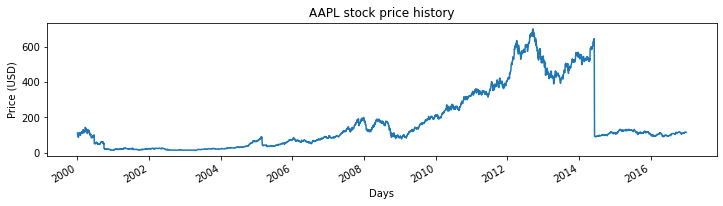

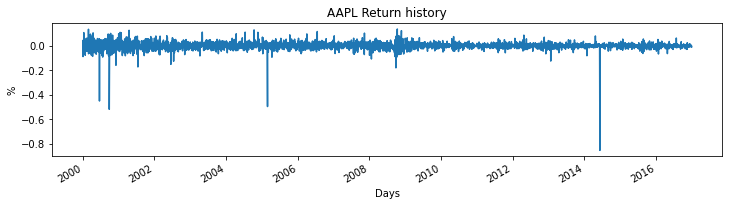

In [20]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
df.AAPL.plot()
plt.title('AAPL stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')


plt.figure(figsize=(12,6))
plt.subplot(2,1,2)
returns.AAPL.plot()
plt.title('AAPL Return history')
plt.ylabel('%')
plt.xlabel('Days')

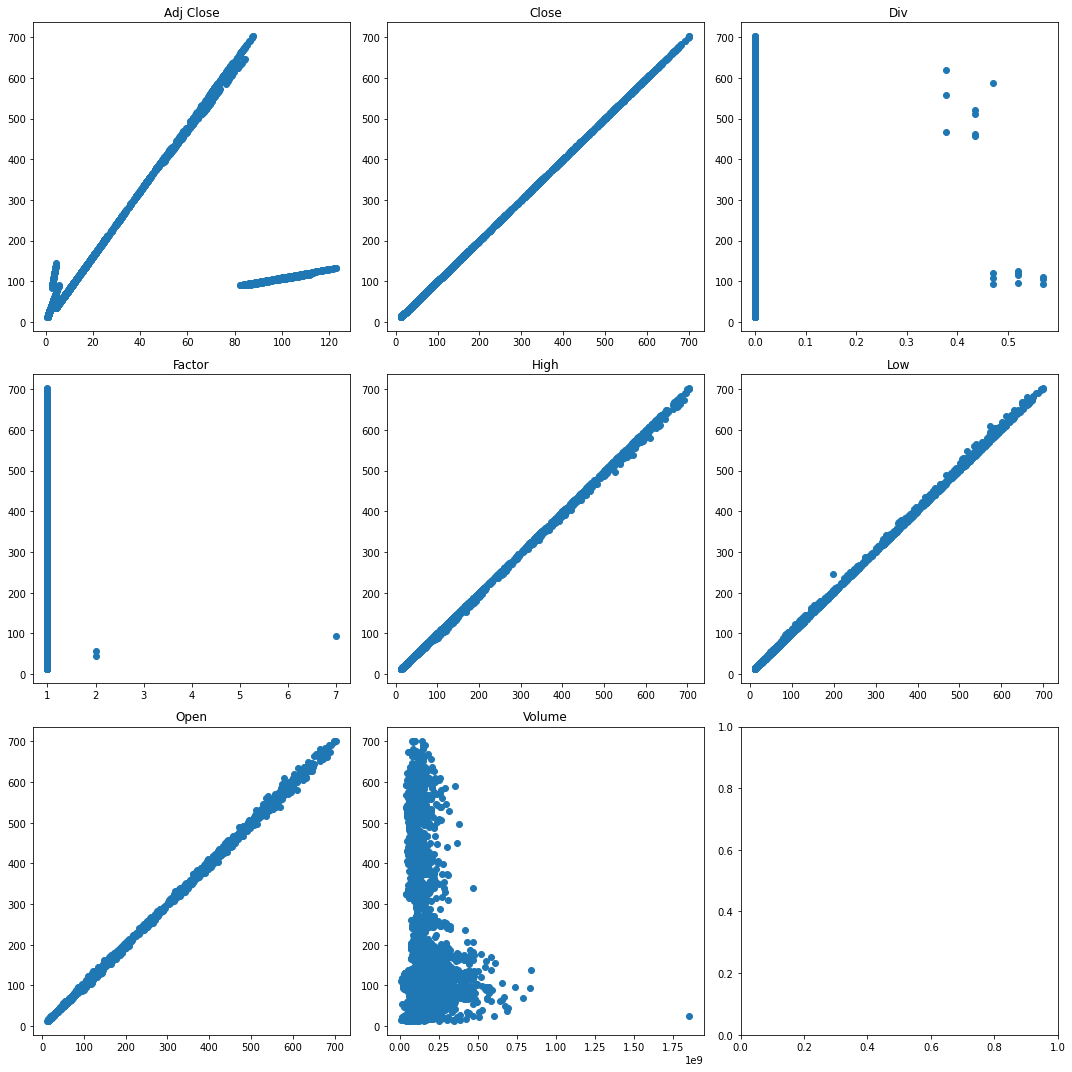

In [21]:
figure,ax = plt.subplots(3,3,figsize=(15,15))
plt.figsize=(6,3)
for i in range(0,8):
  plt.subplot(3,3,i+1)
  plt.scatter(aapl.iloc[:,i], aapl["Close"])
  plt.title(f"{aapl.columns[i]}")
plt.tight_layout() 

As we see that there is no relationship between close and [Factor, Div, Volume]. I will not consider these factors as well as adjusted close, since it is ajusted from close.

In [0]:
col_names = ['Close', 'High', 'Low', 'Open']

In [0]:
aapl = pd.read_csv('./data/train/AAPL.csv', index_col='Dt', parse_dates=True).loc[:,col_names]

2. Explore the relationship between AAPL and other stocks and indexes

  a) Below pictures shows that it's hard to tell the relationship between AAPL and other stocks because their prices range are so much different, we should reconsider of scaling them.

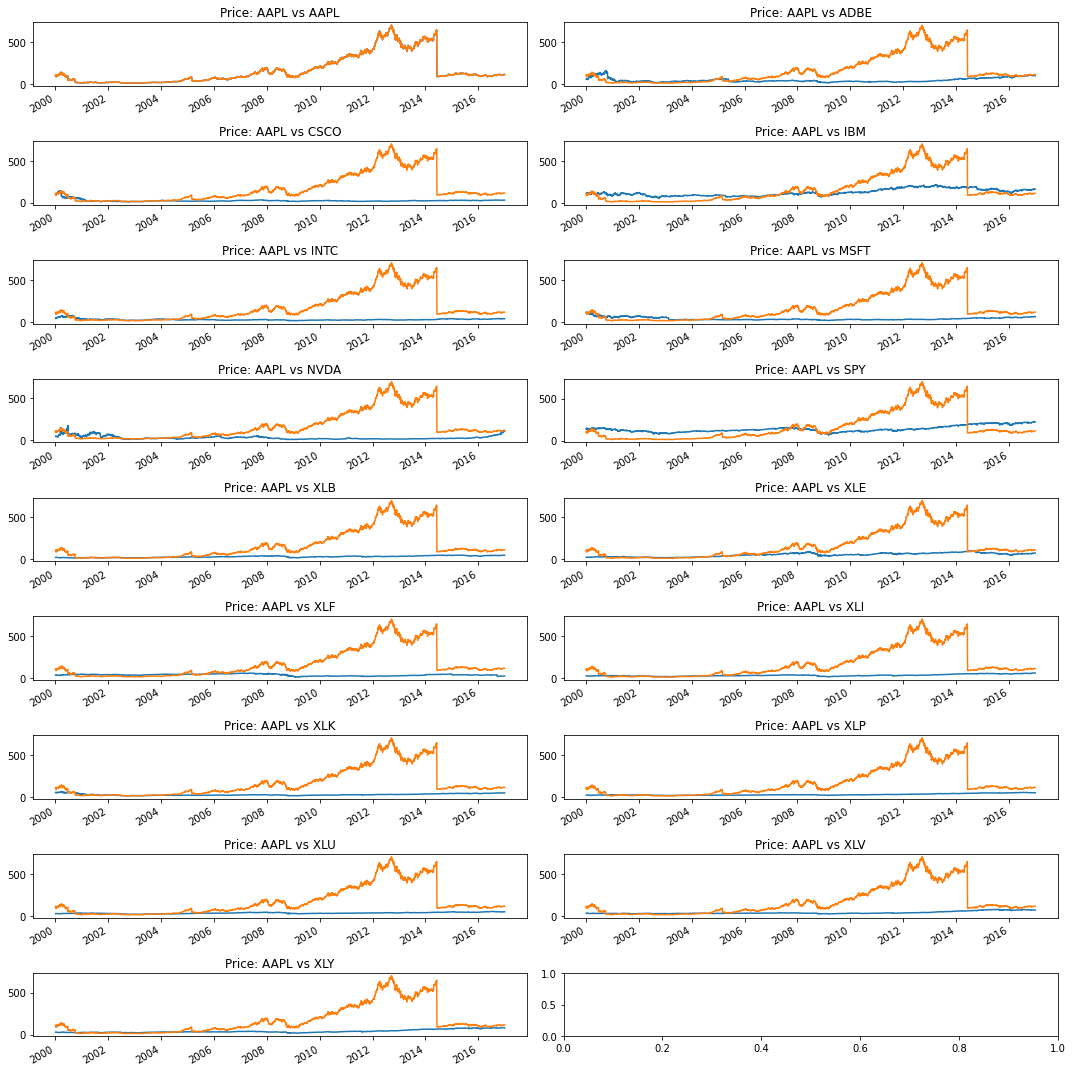

In [24]:
figure,ax = plt.subplots(9,2,figsize=(15,15))
plt.figsize=(12,6)
for i in range(1,18):
  plt.subplot(9,2,i)
  df[remain_list[i-1]].iloc[1:].plot()
  df.AAPL.plot()
  plt.title(f"Price: AAPL vs {remain_list[i-1]}")
plt.tight_layout() 

2. b) Here I use MinMaxScaler function to rescale all prices setting the range between 0 and 1

In [0]:
sc = MinMaxScaler(feature_range = (0, 1))

In [0]:
df_scaled = sc.fit_transform(df)

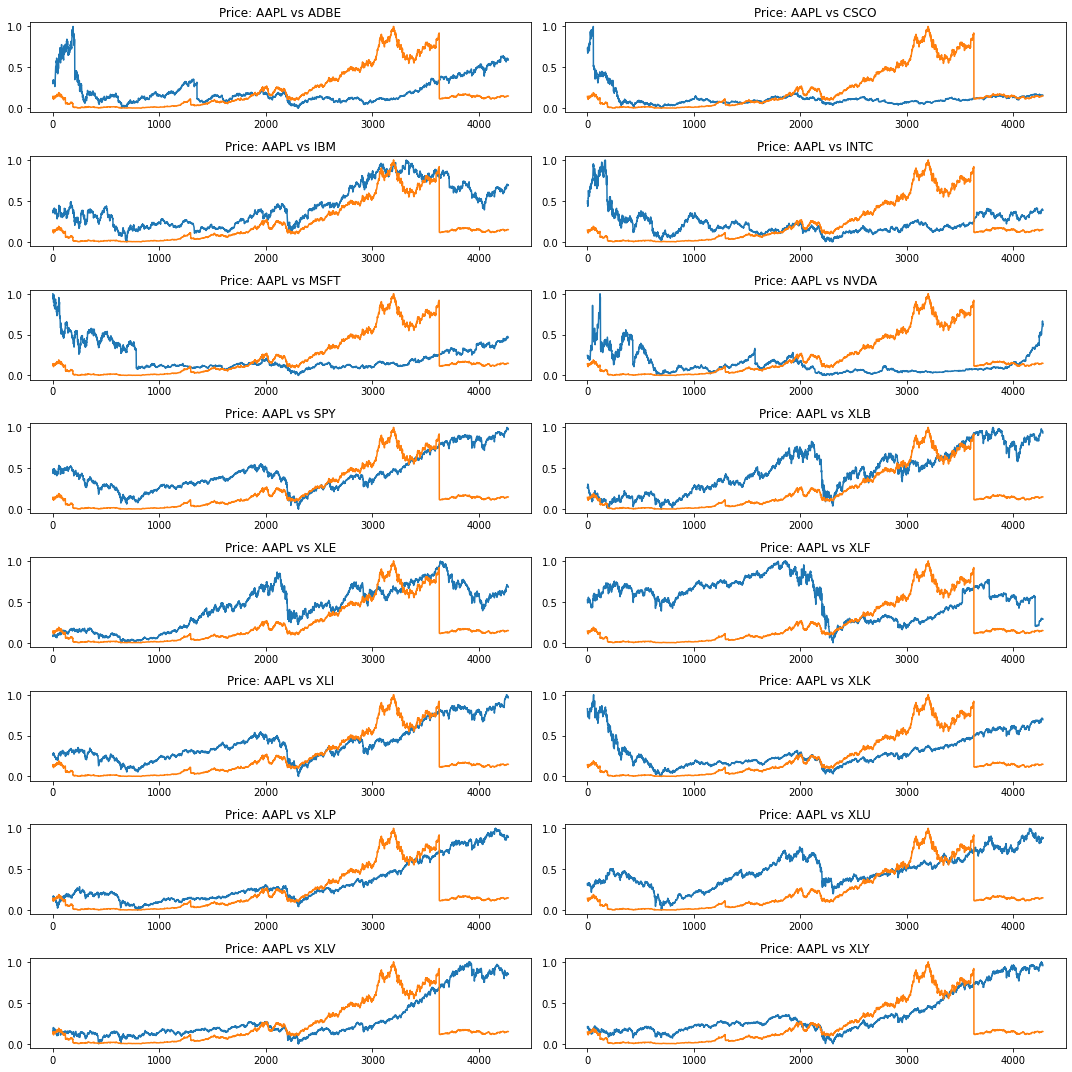

In [27]:
figure,ax = plt.subplots(8,2,figsize=(15,15))
plt.figsize=(12,6)
for i in range(1,17):
  plt.subplot(8,2,i)
  plt.plot(df_scaled[:,i])
  plt.plot(df_scaled[:,0])
  plt.title(f"Price: AAPL vs {remain_list[i]}")
plt.tight_layout() 

3. We could see some patterns between AAPL and others, let's check out their covariance

In [28]:
corr = df.corr().iloc[7:,:7]
corr

,AAPL,ADBE,CSCO,IBM,INTC,MSFT,NVDA
SPY,0.229092,0.705521,0.251708,0.605777,0.420696,0.340983,0.225488
XLB,0.453013,0.319154,-0.052365,0.686915,-0.009539,-0.113247,-0.170606
XLE,0.645772,0.125242,-0.106493,0.763473,-0.127564,-0.261314,-0.280608
XLF,-0.495544,0.157472,0.105026,-0.448521,0.166692,0.119511,0.304027
XLI,0.318726,0.575807,0.085791,0.660339,0.243427,0.178026,0.080610
XLK,0.153965,0.872418,0.675677,0.507171,0.803440,0.670579,0.506067
XLP,0.367308,0.543716,0.024169,0.726191,0.207115,0.210923,0.009482
XLU,0.318413,0.467722,0.074916,0.605050,0.164250,0.109034,0.113214
XLV,0.207846,0.601550,0.063623,0.591713,0.246194,0.230825,0.031056
XLY,0.307659,0.557659,0.018954,0.655257,0.204743,0.174894,0.005466


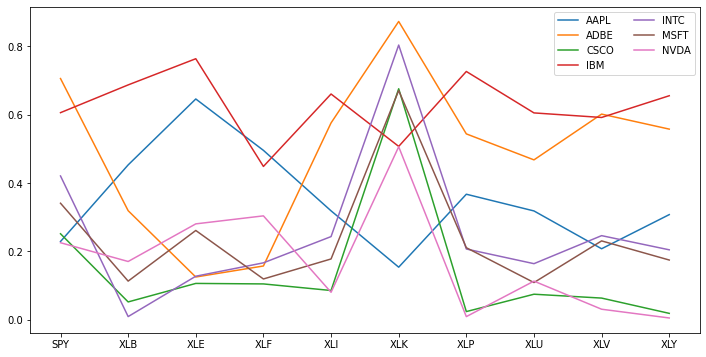

In [29]:
plt.figure(figsize=(12,6))
for i in corr:
  plt.plot(abs(corr[i]),label=i)
plt.legend(ncol=2)

The conclusion is that for all tech companies, the strong indexes correlating with them are SPY and XLK because for these two indexes, the corresponding correlation coefficients are almost all greater than 0.2. What's more, from below indexes description, we also know that XLK is the technology select sector, so we should include it in our analysis.

<table style="width:100%">
<tr>
<th>Ticker</th>
<th>Definition</th>
</tr>

<tr>
<td>XLB</td>
<td>Materials Select Sector SPDR Fund</td>
</tr>

<tr>
<td>XLE</td>
<td>Energy Select Sector SPDR Fund</td>
</tr>

<tr>
<td>XLF</td>
<td>Financial Select Sector SPDR Fund</td>
</tr>

<tr>
<td>XLI</td>
<td>Industrial Select Sector SPDR Fund</td>
</tr>

<tr>
<td>XLK</td>
<td>Technology Select Sector SPDR Fund</td>
</tr>

<tr>
<td>XLP</td>
<td>Consumer Staples Select Sector SPDR Fund</td>
</tr>

<tr>
<td>XLRE</td>
<td>The Real Estate Select Sector SPDR Fund</td>
</tr>

<tr>
<td>XLU</td>
<td>Utilities Select Sector SPDR Fund</td>
</tr>

<tr>
<td>XLV</td>
<td>Health Care Select Sector SPDR Fund</td>
</tr>

<tr>
<td>XLY</td>
<td>Consumer Discretionary Select Sector SPDR Fund</td>
</tr>
</table>

# Utilities/Model Designs:
## Preface: 
### 1) the idea of features_engine() function is to create 7-days time lags of each feature we need in model, for example, for Open price, there will be $Open_{t-7}, Open_{t-6}, Open_{t-5}, Open_{t-4}, Open_{t-3}, Open_{t-2}, Open_{t-1}$. In this way, we could create a bunches of features. This idea is from time series ARMA model.

### 2) split_data() function is helping to split x and y data into test and train set

### 3) we also need create_timestemps() function to create a 3-dimensions features dataset that could be applied for LSTM model which requires 3-dimension features input shape. Basic idea of this function is to group every 60-days data together corresponding with a y data at each $60^{th}$ day. In my opinion, since LSTM could help us to decide how long a data could give an effect to current predictions, we could control manipulate this so-called "60" days memory and find out the idea memory length. The default days is 60.

### 4) createModel() is a basic model mainly working with LSTM layers. Notice, in the final LSTM layer, I set return_sequences to False, so the output shape is 2 dimensions. I do not specify any activation but use default setting that is linear since it is a regression problem and we are interested in predicting numerical values directly without transform.

### 5) Scaling/Normalization before PCA: The reason why standardization is very much needed before performing PCA is that PCA is very sensitive to variances. Meaning, if there are large differences between the scales (ranges) of the features, then those with larger scales will dominate over those with the small scales. Resource: https://towardsdatascience.com/a-complete-guide-to-principal-component-analysis-pca-in-machine-learning-664f34fc3e5a

### 6) PCA function: is an unsupervised, non-parametric statistical technique primarily used for dimensionality reduction in machine learning. High dimensionality means that the dataset has a large number of features. The primary problem associated with high-dimensionality in the machine learning field is model overfitting, which reduces the ability to generalize beyond the examples in the training set.

### 7) Loss Function: Mean squared error (MSE) — This finds the average squared difference between the predicted value and the true value. Because it is hard to predict the stock price then to the precise returns (if we can do it, we will be the richest people in the world), MSE is the best loss function we use


In [0]:
# Using time-lag idea to get more features
def features_engine(temp):
  data = pd.DataFrame()
  for i in range(temp.shape[1]):
    for j in range(7):
      col_names = temp.columns[i]+":"+str(7-j)+"-days-ago"
      data[col_names]=temp[temp.columns[i]][j:].shift(6-j)
  data = data[6:]
  return data

In [0]:
def split_data(x_data, y_data):
  split = round(len(x_data)*0.8)
  x_test = x_data[split:]
  x_train = x_data[:split]

  y_test = y_data[split:]
  y_train = y_data[:split]
  return x_train,x_test,y_train,y_test

In [0]:
def create_timesteps(X, Y, days=60):
  x = []
  y = []

  for i in range(days, X.shape[0]):
      x.append(X[i-days:i]) # 每60行做一组xi
      y.append(Y[i]) # 每60的倍数作为yi
  x, y = np.array(x), np.array(y)

  # Reshaping
  # x = np.reshape(x, (x.shape[0], x.shape[1], X.shape[1]))
  print("x.shape: ", x.shape)
  print("y.shape: ", y.shape)
  return x, y

In [0]:
def createModel(input_shape, num_filters=[50,50,50], pool=[1,1], extraDense=True):
  # Create first layer: needs input_spec
  model = Sequential()
  print("Adding Pool + LSTM block with {n:d} filters".format(n=num_filters[0]))
  model.add(LSTM(units = num_filters[0], return_sequences = True, input_shape=input_shape))
  # model.add(Dropout(0.25))

  # Add more Conv/Pooling layers
  for i in range(1, len(num_filters)-1):   
    if  (len(pool) > i) and pool[i]:
      print("Adding Pool + LSTM block with {n:d} filters".format(n=num_filters[i]))
      model.add(MaxPooling1D(pool_size=2,padding='SAME'))
      
    else:
      print("Adding LSTM block with {n:d} filters".format(n=num_filters[i]))

    model.add(LSTM(units = num_filters[i], return_sequences=True))
    model.add(Dropout(0.25))
  
  model.add(LSTM(units = num_filters[i], return_sequences=False))
  model.add(Dropout(0.25))
  
  if extraDense:
    model.add(BatchNormalization())
    #model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))

  model.add(Dense(1, activation='relu'))

  return model

In [0]:
def trainModel(model, modelName, X_train, y_train, X_test, y_test, batch_size = 128, epochs=20, num_classes=10):
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=.0005, 
                          patience=10, 
                          verbose=0, 
                          mode='auto', 
                          baseline=None, 
                          restore_best_weights=True)

  callbacks = [es_callback, ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)]   

  model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=["mse"])

  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)
  

  model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=callbacks,
            validation_data=(X_test, y_test)
            )
  
  score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  return score[1], plotFile

# Start from here, we take AAPL as an example to analysis more features that could help us to predict returns

## First, we predict the returns directly from AAPL's features: High, Low, Open, Volume

set train and test set for AAPL

In [35]:
{"AAPL:":aapl,"return": returns.AAPL}

{'AAPL:':               Close      High      Low      Open
 Dt                                              
 2000-01-03  111.938  112.5000  101.688  104.8750
 2000-01-04  102.500  110.6250  101.188  108.2500
 2000-01-05  104.000  110.5630  103.000  103.7500
 2000-01-06   95.000  107.0000   95.000  106.1183
 2000-01-07   99.500  101.0000   95.500   96.5000
 ...             ...       ...      ...       ...
 2016-12-23  116.520  116.5255  115.590  115.5900
 2016-12-27  117.260  117.8000  116.490  116.5200
 2016-12-28  116.760  118.0170  116.200  117.5200
 2016-12-29  116.730  117.1094  116.400  116.4500
 2016-12-30  115.820  117.2000  115.430  116.6577
 
 [4277 rows x 4 columns], 'return': 2000-01-04   -0.084315
 2000-01-05    0.014634
 2000-01-06   -0.086538
 2000-01-07    0.047368
 2000-01-10   -0.017588
                 ...   
 2016-12-23    0.001978
 2016-12-27    0.006351
 2016-12-28   -0.004264
 2016-12-29   -0.000257
 2016-12-30   -0.007796
 Name: AAPL, Length: 4276, dtype: float6

In [36]:
# features engine
data_featured=features_engine(aapl)

# Get x and y data
x_data = data_featured.iloc[1:,1:].copy().values
y_data = returns.AAPL.copy().values[6:]

# Feature Scaling Normalization
sc = MinMaxScaler(feature_range = (0, 1))
x_data_sc = sc.fit_transform(x_data)

# PCA to reduce dimension
pca = PCA(n_components=0.99)
x_data_pca = pca.fit_transform(x_data_sc)

x_train,x_test,y_train,y_test = split_data(x_data_pca,y_data)

x_train, y_train = create_timesteps(x_train, y_train, days=60)
x_test, y_test = create_timesteps(x_test, y_test, days=60)

x.shape:  (3356, 60, 1)
y.shape:  (3356,)
x.shape:  (794, 60, 1)
y.shape:  (794,)


In [37]:
model1 = createModel(input_shape=(x_train.shape[1],x_train.shape[2]))
modelName="model1"

acc, plotFile= trainModel(model1, modelName, x_train, y_train, x_test, y_test, epochs=40)
# IPython.display.Image(plotFile)

Adding Pool + LSTM block with 50 filters
Adding Pool + LSTM block with 50 filters
Epoch 1/40
27/27 [==============================] - 1s 45ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 2/40
27/27 [==============================] - 0s 13ms/step - loss: 9.4349e-04 - mse: 9.4349e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 3/40
27/27 [==============================] - 0s 12ms/step - loss: 9.4349e-04 - mse: 9.4349e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 4/40
27/27 [==============================] - 0s 12ms/step - loss: 9.4349e-04 - mse: 9.4349e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 5/40
27/27 [==============================] - 0s 12ms/step - loss: 9.4349e-04 - mse: 9.4349e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 6/40
27/27 [==============================] - 0s 12ms/step - loss: 9.4349e-04 - mse: 9.4349e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 7/40
27/27 [==============================] - 0s 14ms/step - loss: 9.4349e-04 - mse: 9

In [38]:
y_pred_model1_test=model1.predict(x_test)
print(f"The mean-square-error is:\t{mean_squared_error(y_test, y_pred_model1_test):0.3f}")

The mean-square-error is:	0.001


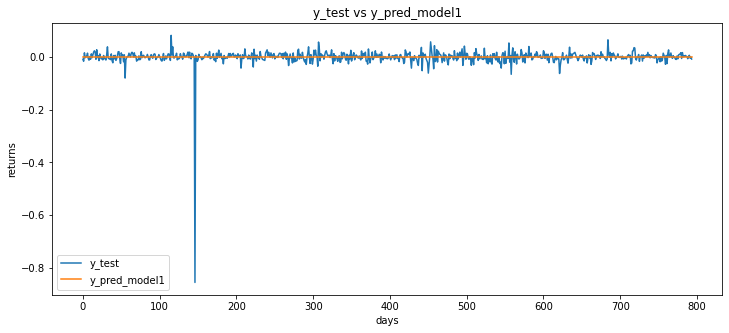

In [39]:
plt.figure(figsize=(12,5))
plt.plot(y_test, label = 'y_test')
plt.plot(y_pred_model1_test, label = 'y_pred_model1')
plt.xlabel('days')
plt.ylabel('returns')
plt.title('y_test vs y_pred_model1')
plt.legend()

### Conclusion: it is looks good that almost all predict returns are around 0 by using only parameter Close, High, Low, Open. Because today's price is based on yesterday's price, so they are closed to each other normally and returns are seemly unchanged. But the accuracy is pretty low

## Let's predict the price first instead of returns, and then we calculate our returns eventually.

In [42]:
# Features engine
data_featured[:3]

,Close:7-days-ago,Close:6-days-ago,Close:5-days-ago,Close:4-days-ago,Close:3-days-ago,Close:2-days-ago,Close:1-days-ago,High:7-days-ago,High:6-days-ago,High:5-days-ago,High:4-days-ago,High:3-days-ago,High:2-days-ago,High:1-days-ago,Low:7-days-ago,Low:6-days-ago,Low:5-days-ago,Low:4-days-ago,Low:3-days-ago,Low:2-days-ago,Low:1-days-ago,Open:7-days-ago,Open:6-days-ago,Open:5-days-ago,Open:4-days-ago,Open:3-days-ago,Open:2-days-ago,Open:1-days-ago
Dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-11,111.938,102.5,104.0,95.00,99.50,97.750,92.750,112.500,110.625,110.563,107.00,101.000,102.2500,99.3750,101.688,101.188,103.0,95.00,95.50,94.75,90.5,104.875,108.2500,103.7500,106.1183,96.500,102.000,95.938
2000-01-12,102.500,104.0,95.0,99.50,97.75,92.750,87.188,110.625,110.563,107.000,101.00,102.250,99.3750,95.5012,101.188,103.000,95.0,95.50,94.75,90.50,86.5,108.250,103.7500,106.1183,96.5000,102.000,95.938,95.000
2000-01-13,104.000,95.0,99.5,97.75,92.75,87.188,96.750,110.563,107.000,101.000,102.25,99.375,95.5012,98.7500,103.000,95.000,95.5,94.75,90.50,86.50,92.5,103.750,106.1183,96.5000,102.0000,95.938,95.000,94.484


In [43]:
x_data2 = data_featured.iloc[:,1:]
y_data2 = np.array(data_featured.iloc[:,0]).reshape(-1,1)

# Feature Scaling Normalization
sc = MinMaxScaler(feature_range = (0, 1))
x_data2_sc = sc.fit_transform(x_data2)
y_data2_sc = sc.fit_transform(y_data2)

# PCA to reduce dimension
pca = PCA(n_components=0.99)
x_data2_pca = pca.fit_transform(x_data2_sc)

# split data
x_train2,x_test2,y_train2,y_test2 = split_data(x_data2_pca,y_data2_sc)

# time-stemp to reshape x to 3 dimension
x_train2, y_train2 = create_timesteps(x_train2, y_train2, days=60)
x_test2, y_test2 = create_timesteps(x_test2, y_test2, days=60)

x.shape:  (3357, 60, 1)
y.shape:  (3357, 1)
x.shape:  (794, 60, 1)
y.shape:  (794, 1)


In [44]:
model2 = createModel(input_shape=(x_train2.shape[1],x_train2.shape[2]))
modelName="model2"

acc, plotFile = trainModel(model2, modelName, x_train2, y_train2, x_test2, y_test2, epochs=40)
# IPython.display.Image(plotFile)

Adding Pool + LSTM block with 50 filters
Adding Pool + LSTM block with 50 filters
Epoch 1/40
27/27 [==============================] - 1s 41ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.1069 - val_mse: 0.1069
Epoch 2/40
27/27 [==============================] - 0s 13ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.1042 - val_mse: 0.1042
Epoch 3/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.1003 - val_mse: 0.1003
Epoch 4/40
27/27 [==============================] - 0s 13ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0900 - val_mse: 0.0900
Epoch 5/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0858 - val_mse: 0.0858
Epoch 6/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0848 - val_mse: 0.0848
Epoch 7/40
27/27 [==============================] - 0s 13ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0788 - val_mse: 0.0788
E

In [45]:
y_pred_model2_test=model2.predict(x_test2)
print(f"The mean-square-error of prices is:\t{mean_squared_error(y_test2, y_pred_model2_test):0.3f}")

y_pred_original2 = sc.inverse_transform(y_pred_model2_test)
y_test_original2 = sc.inverse_transform(y_test2)
y_pred2_r = pd.DataFrame(y_pred_original2).pct_change(1)
y_test2_r = pd.DataFrame(y_test_original2).pct_change(1)
print(f"The mean-square-error of returns is:\t{mean_squared_error(y_test2_r[1:], y_pred2_r[1:]):0.3f}")

The mean-square-error of prices is:	0.005
The mean-square-error of returns is:	0.003


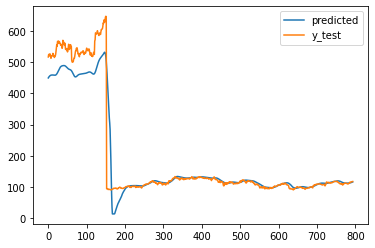

In [46]:
plt.figure()
plt.plot(y_pred_original2, label="predicted")
plt.plot(y_test_original2, label="y_test")
plt.legend(loc = "upper right")
plt.show()

### Conclusion: In this method, the accuracy has increase dramatically compared with the first model. It is 10 times higher than the first model.

## Right now let's add in more stocks to predict AAPL's returns, also start from prices first

In [47]:
remain_list = sorted(list(set(remain_list)-set(['XLB','XLE','XLF','XLI','XLP','XLU','XLV','XLY'])))
remain_list

['AAPL', 'ADBE', 'CSCO', 'IBM', 'INTC', 'MSFT', 'NVDA', 'SPY', 'XLK']

In [0]:
col_names = ['Close', 'High', 'Low', 'Open']

In [0]:
lst = []
for i in range(len(remain_list)):
  lst.append(pd.read_csv(f'./data/train/{remain_list[i]}.csv',index_col='Dt', parse_dates=True).loc[:,col_names])
  lst[i].rename(columns={'Close':f'{remain_list[i]}-Close', 'High':f'{remain_list[i]}-high', 'Low':f'{remain_list[i]}-Low', 'Open':f'{remain_list[i]}-Open'}, inplace=True)

df = pd.concat([i for i in lst], axis=1, ignore_index=False) # first 5 attributes belongs to AAPL

In [50]:
df.head()

,AAPL-Close,AAPL-high,AAPL-Low,AAPL-Open,ADBE-Close,ADBE-high,ADBE-Low,ADBE-Open,CSCO-Close,CSCO-high,CSCO-Low,CSCO-Open,IBM-Close,IBM-high,IBM-Low,IBM-Open,INTC-Close,INTC-high,INTC-Low,INTC-Open,MSFT-Close,MSFT-high,MSFT-Low,MSFT-Open,NVDA-Close,NVDA-high,NVDA-Low,NVDA-Open,SPY-Close,SPY-high,SPY-Low,SPY-Open,XLK-Close,XLK-high,XLK-Low,XLK-Open
Dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,111.938,112.500,101.688,104.8750,65.563,67.500,64.250,67.2500,108.063,110.250,103.563,109.9380,116.000,116.000,111.8750,112.438,43.500,43.6880,41.625,41.633,116.563,118.625,112.000,117.375,46.813,47.6250,44.125,47.250,145.438,148.2472,143.875,148.250,55.438,55.625,53.5000,55.625
2000-01-04,102.500,110.625,101.188,108.2500,60.063,65.813,59.938,63.0000,102.000,107.000,101.750,105.5000,112.063,114.500,110.8750,114.000,41.469,43.9380,41.125,42.719,112.625,117.125,112.250,113.563,45.563,46.1250,43.250,46.000,139.750,144.0630,139.641,143.531,52.625,54.750,52.3130,54.000
2000-01-05,104.000,110.563,103.000,103.7500,61.250,62.750,58.250,58.2500,101.688,104.500,97.250,100.0630,116.000,119.750,112.1250,112.938,41.813,42.9345,40.250,41.500,113.813,116.375,109.375,111.125,44.063,45.0000,43.438,44.250,140.000,141.5284,137.250,139.938,51.844,53.063,50.1250,51.750
2000-01-06,95.000,107.000,95.000,106.1183,61.750,62.625,60.625,61.4393,100.000,101.875,98.625,100.8130,114.000,118.938,113.5004,118.000,39.375,41.6880,39.094,40.875,110.000,113.875,108.375,112.188,41.188,44.0630,39.500,44.063,137.750,141.5000,137.750,139.625,50.125,52.094,49.6250,51.250
2000-01-07,99.500,101.000,95.500,96.5000,64.750,64.750,60.875,61.5630,105.875,106.000,99.375,99.3751,113.500,117.938,110.6250,117.250,41.000,41.0000,38.688,38.750,111.438,112.250,107.313,108.625,41.875,42.3174,40.375,41.000,145.750,145.7500,140.063,140.313,51.000,51.000,49.1263,49.625


In [52]:
# Features engine
df_featured = features_engine(df)

# split
x_data3 = df_featured.iloc[:,1:]
y_data3 = np.array(df_featured.iloc[:,0]).reshape(-1,1)

# Feature Scaling Normalization
sc = MinMaxScaler(feature_range = (0, 1))
x_data3_sc = sc.fit_transform(x_data3)
y_data3_sc = sc.fit_transform(y_data3)

# PCA to reduce dimension
pca = PCA(n_components=0.99)
x_data3_pca = pca.fit_transform(x_data3_sc)

# split data
x_train3,x_test3,y_train3,y_test3 = split_data(x_data3_pca,y_data3_sc)

# time-stemp to reshape x to 3 dimension
x_train3, y_train3 = create_timesteps(x_train3, y_train3, days=60)
x_test3, y_test3 = create_timesteps(x_test3, y_test3, days=60)

x.shape:  (3357, 60, 8)
y.shape:  (3357, 1)
x.shape:  (794, 60, 8)
y.shape:  (794, 1)


In [53]:
model3 = createModel(input_shape=(x_train3.shape[1],x_train3.shape[2]))
modelName="model3"

acc, plotFile = trainModel(model3, modelName, x_train3, y_train3, x_test3, y_test3, epochs=40)
# IPython.display.Image(plotFile)

Adding Pool + LSTM block with 50 filters
Adding Pool + LSTM block with 50 filters
Epoch 1/40
27/27 [==============================] - 1s 42ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0968 - val_mse: 0.0968
Epoch 2/40
27/27 [==============================] - 0s 13ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0884 - val_mse: 0.0884
Epoch 3/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0810 - val_mse: 0.0810
Epoch 4/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 5/40
27/27 [==============================] - 0s 14ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 6/40
27/27 [==============================] - 0s 14ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0559 - val_mse: 0.0559
Epoch 7/40
27/27 [==============================] - 0s 13ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0519 - val_mse: 0.0519
E

In [54]:
y_pred_model3_test=model3.predict(x_test3)
print(f"The mean-square-error is:\t{mean_squared_error(y_test3, y_pred_model3_test):0.3f}")

The mean-square-error is:	0.006


In [55]:
y_pred_original3 = sc.inverse_transform(y_pred_model3_test)
y_test_original3 = sc.inverse_transform(y_test3)
y_pred3_r = pd.DataFrame(y_pred_original3).pct_change(1)
y_test3_r = pd.DataFrame(y_test_original3).pct_change(1)
print(f"The mean-square-error is:\t{mean_squared_error(y_test3_r[1:], y_pred3_r[1:]):0.3f}")

The mean-square-error is:	0.001


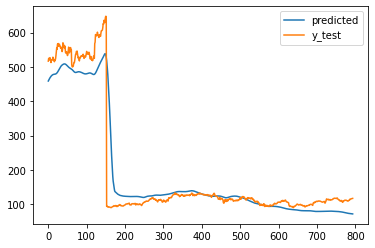

In [56]:
plt.figure()
plt.plot(y_pred_original3, label="predicted")
plt.plot(y_test_original3, label="y_test")
plt.legend(loc = "upper right")
plt.show()

### From the graph, we know that the prediction is not that good as the model2 is, the predicted price is lower than the test set in the second half of the time. This model overfits obviously, but it is hard to say that is not a good model because the accuracy increases a little bit.

## With same features but predict returns directly

In [0]:
# Features engine
df_featured = features_engine(df)

# split
x_data32 = df_featured.iloc[:,1:]

In [59]:
x_data32.head()

,AAPL-Close:6-days-ago,AAPL-Close:5-days-ago,AAPL-Close:4-days-ago,AAPL-Close:3-days-ago,AAPL-Close:2-days-ago,AAPL-Close:1-days-ago,AAPL-high:7-days-ago,AAPL-high:6-days-ago,AAPL-high:5-days-ago,AAPL-high:4-days-ago,AAPL-high:3-days-ago,AAPL-high:2-days-ago,AAPL-high:1-days-ago,AAPL-Low:7-days-ago,AAPL-Low:6-days-ago,AAPL-Low:5-days-ago,AAPL-Low:4-days-ago,AAPL-Low:3-days-ago,AAPL-Low:2-days-ago,AAPL-Low:1-days-ago,AAPL-Open:7-days-ago,AAPL-Open:6-days-ago,AAPL-Open:5-days-ago,AAPL-Open:4-days-ago,AAPL-Open:3-days-ago,AAPL-Open:2-days-ago,AAPL-Open:1-days-ago,ADBE-Close:7-days-ago,ADBE-Close:6-days-ago,ADBE-Close:5-days-ago,ADBE-Close:4-days-ago,ADBE-Close:3-days-ago,ADBE-Close:2-days-ago,ADBE-Close:1-days-ago,ADBE-high:7-days-ago,ADBE-high:6-days-ago,ADBE-high:5-days-ago,ADBE-high:4-days-ago,ADBE-high:3-days-ago,ADBE-high:2-days-ago,...,SPY-Low:5-days-ago,SPY-Low:4-days-ago,SPY-Low:3-days-ago,SPY-Low:2-days-ago,SPY-Low:1-days-ago,SPY-Open:7-days-ago,SPY-Open:6-days-ago,SPY-Open:5-days-ago,SPY-Open:4-days-ago,SPY-Open:3-days-ago,SPY-Open:2-days-ago,SPY-Open:1-days-ago,XLK-Close:7-days-ago,XLK-Close:6-days-ago,XLK-Close:5-days-ago,XLK-Close:4-days-ago,XLK-Close:3-days-ago,XLK-Close:2-days-ago,XLK-Close:1-days-ago,XLK-high:7-days-ago,XLK-high:6-days-ago,XLK-high:5-days-ago,XLK-high:4-days-ago,XLK-high:3-days-ago,XLK-high:2-days-ago,XLK-high:1-days-ago,XLK-Low:7-days-ago,XLK-Low:6-days-ago,XLK-Low:5-days-ago,XLK-Low:4-days-ago,XLK-Low:3-days-ago,XLK-Low:2-days-ago,XLK-Low:1-days-ago,XLK-Open:7-days-ago,XLK-Open:6-days-ago,XLK-Open:5-days-ago,XLK-Open:4-days-ago,XLK-Open:3-days-ago,XLK-Open:2-days-ago,XLK-Open:1-days-ago
Dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-11,102.50,104.00,95.000,99.500,97.750,92.750,112.500,110.625,110.563,107.0000,101.0000,102.2500,99.3750,101.688,101.188,103.00,95.00,95.50,94.750,90.500,104.8750,108.2500,103.7500,106.1183,96.500,102.000,95.938,65.563,60.063,61.250,61.750,64.750,67.250,62.625,67.500,65.813,62.750,62.625,64.750,67.250,...,137.250,137.750,140.063,145.031,143.500,148.250,143.531,139.938,139.625,140.313,146.250,145.813,55.438,52.625,51.844,50.125,51.000,52.938,51.438,55.625,54.750,53.063,52.094,51.000,53.438,53.469,53.5000,52.3130,50.1250,49.6250,49.1263,52.063,51.188,55.625,54.000,51.750,51.250,49.625,53.000,53.000
2000-01-12,104.00,95.00,99.500,97.750,92.750,87.188,110.625,110.563,107.000,101.0000,102.2500,99.3750,95.5012,101.188,103.000,95.00,95.50,94.75,90.500,86.500,108.2500,103.7500,106.1183,96.5000,102.000,95.938,95.000,60.063,61.250,61.750,64.750,67.250,62.625,62.313,65.813,62.750,62.625,64.750,67.250,67.250,...,137.750,140.063,145.031,143.500,142.875,143.531,139.938,139.625,140.313,146.250,145.813,144.594,52.625,51.844,50.125,51.000,52.938,51.438,51.219,54.750,53.063,52.094,51.000,53.438,53.469,52.375,52.3130,50.1250,49.6250,49.1263,52.0630,51.188,50.625,54.000,51.750,51.250,49.625,53.000,53.000,52.375
2000-01-13,95.00,99.50,97.750,92.750,87.188,96.750,110.563,107.000,101.000,102.2500,99.3750,95.5012,98.7500,103.000,95.000,95.50,94.75,90.50,86.500,92.500,103.7500,106.1183,96.5000,102.0000,95.938,95.000,94.484,61.250,61.750,64.750,67.250,62.625,62.313,65.625,62.750,62.625,64.750,67.250,67.250,63.375,...,140.063,145.031,143.500,142.875,143.281,139.938,139.625,140.313,146.250,145.813,144.594,144.469,51.844,50.125,51.000,52.938,51.438,51.219,51.688,53.063,52.094,51.000,53.438,53.469,52.375,52.000,50.1250,49.6250,49.1263,52.0630,51.1880,50.625,50.875,51.750,51.250,49.625,53.000,53.000,52.375,51.875
2000-01-14,99.50,97.75,92.750,87.188,96.750,100.438,107.000,101.000,102.250,99.3750,95.5012,98.7500,102.2500,95.000,95.500,94.75,90.50,86.50,92.500,99.375,106.1183,96.5000,102.0000,95.9380,95.000,94.484,100.000,61.750,64.750,67.250,62.625,62.313,65.625,66.313,62.625,64.750,67.250,67.250,63.375,66.000,...,145.031,143.500,142.875,143.281,145.969,139.625,140.313,146.250,145.813,144.594,144.469,146.531,50.125,51.000,52.938,51.438,51.219,51.688,52.87

In [60]:
# Features engine
df_featured = features_engine(df)

# split
x_data32 = df_featured.iloc[:,1:]
y_data32 = np.array(returns.AAPL[5:]).reshape(-1,1)

# Feature Scaling Normalization
sc = MinMaxScaler(feature_range = (0, 1))
x_data32_sc = sc.fit_transform(x_data32)

# PCA to reduce dimension
pca = PCA(n_components=0.99)
x_data32_pca = pca.fit_transform(x_data32_sc)

# split data
x_train32,x_test32,y_train32,y_test32 = split_data(x_data32_pca,y_data32)

# time-stemp to reshape x to 3 dimension
x_train32, y_train32 = create_timesteps(x_train32, y_train32, days=60)
x_test32, y_test32 = create_timesteps(x_test32, y_test32, days=60)

model32 = createModel(input_shape=(x_train32.shape[1],x_train32.shape[2]))
modelName="model32"

acc, plotFile = trainModel(model32, modelName, x_train32, y_train32, x_test32, y_test32, epochs=40)
# IPython.display.Image(plotFile)

x.shape:  (3357, 60, 8)
y.shape:  (3357, 1)
x.shape:  (794, 60, 8)
y.shape:  (794, 1)
Adding Pool + LSTM block with 50 filters
Adding Pool + LSTM block with 50 filters
Epoch 1/40
27/27 [==============================] - 1s 42ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 2/40
27/27 [==============================] - 0s 13ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 3/40
27/27 [==============================] - 0s 12ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 4/40
27/27 [==============================] - 0s 12ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 5/40
27/27 [==============================] - 0s 13ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 6/40
27/27 [==============================] - 0s 13ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.001

The mean-square-error is:	0.001


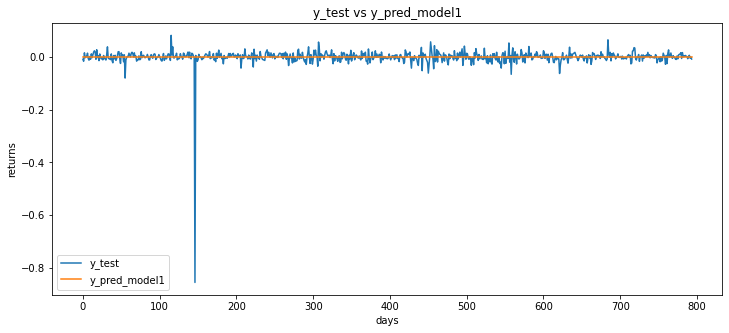

In [61]:
y_pred_model32_test=model32.predict(x_test32)
print(f"The mean-square-error is:\t{mean_squared_error(y_test32, y_pred_model32_test):0.3f}")

plt.figure(figsize=(12,5))
plt.plot(y_test32, label = 'y_test')
plt.plot(y_pred_model32_test, label = 'y_pred_model1')
plt.xlabel('days')
plt.ylabel('returns')
plt.title('y_test vs y_pred_model1')
plt.legend()

## the final model we will only use AAPL, SPY, and XLK and predict price first

In [63]:
lst = []
remain_list1 = ['AAPL','SPY','XLK']
for i in range(len(remain_list1)):
  lst.append(pd.read_csv(f'./data/train/{remain_list1[i]}.csv',index_col='Dt', parse_dates=True).loc[:,col_names])
  lst[i].rename(columns={'Close':f'{remain_list1[i]}-Close', 'High':f'{remain_list1[i]}-high', 'Low':f'{remain_list1[i]}-Low', 'Open':f'{remain_list1[i]}-Open'}, inplace=True)

df = pd.concat([i for i in lst], axis=1, ignore_index=False) # first 5 attributes belongs to AAPL
df.head()

,AAPL-Close,AAPL-high,AAPL-Low,AAPL-Open,SPY-Close,SPY-high,SPY-Low,SPY-Open,XLK-Close,XLK-high,XLK-Low,XLK-Open
Dt,,,,,,,,,,,,
2000-01-03,111.938,112.500,101.688,104.8750,145.438,148.2472,143.875,148.250,55.438,55.625,53.5000,55.625
2000-01-04,102.500,110.625,101.188,108.2500,139.750,144.0630,139.641,143.531,52.625,54.750,52.3130,54.000
2000-01-05,104.000,110.563,103.000,103.7500,140.000,141.5284,137.250,139.938,51.844,53.063,50.1250,51.750
2000-01-06,95.000,107.000,95.000,106.1183,137.750,141.5000,137.750,139.625,50.125,52.094,49.6250,51.250
2000-01-07,99.500,101.000,95.500,96.5000,145.750,145.7500,140.063,140.313,51.000,51.000,49.1263,49.625


In [64]:
# Features engine
df_featured = features_engine(df)

# split
x_data4 = df_featured.iloc[:,1:]
y_data4 = np.array(df_featured.iloc[:,0]).reshape(-1,1)

# Feature Scaling Normalization
sc = MinMaxScaler(feature_range = (0, 1))
x_data4_sc = sc.fit_transform(x_data4)
y_data4_sc = sc.fit_transform(y_data4)

# PCA to reduce dimension
pca = PCA(n_components=0.99)
x_data4_pca = pca.fit_transform(x_data4_sc)

# split data
x_train4,x_test4,y_train4,y_test4 = split_data(x_data4_pca,y_data4_sc)

# time-stemp to reshape x to 3 dimension
x_train4, y_train4 = create_timesteps(x_train4, y_train4)
x_test4, y_test4 = create_timesteps(x_test4, y_test4, days=60)

x.shape:  (3357, 60, 3)
y.shape:  (3357, 1)
x.shape:  (794, 60, 3)
y.shape:  (794, 1)


In [65]:
model4 = createModel(input_shape=(x_train4.shape[1],x_train4.shape[2]))
modelName="model4"

acc, plotFile = trainModel(model4, modelName, x_train4, y_train4, x_test4, y_test4, epochs=40)
# IPython.display.Image(plotFile)

Adding Pool + LSTM block with 50 filters
Adding Pool + LSTM block with 50 filters
Epoch 1/40
27/27 [==============================] - 1s 42ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.1070 - val_mse: 0.1070
Epoch 2/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0953 - val_mse: 0.0953
Epoch 3/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.1017 - val_mse: 0.1017
Epoch 4/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0870 - val_mse: 0.0870
Epoch 5/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0870 - val_mse: 0.0870
Epoch 6/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0852 - val_mse: 0.0852
Epoch 7/40
27/27 [==============================] - 0s 13ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0739 - val_mse: 0.0739
E

In [66]:
y_pred_model4_test=model4.predict(x_test4)
print(f"The mean-square-error is:\t{mean_squared_error(y_test4, y_pred_model4_test):0.3f}")

The mean-square-error is:	0.023


In [67]:
y_pred_original4 = sc.inverse_transform(y_pred_model4_test)
y_test_original4 = sc.inverse_transform(y_test4)
y_pred4_r = pd.DataFrame(y_pred_original4).pct_change(1)
y_test4_r = pd.DataFrame(y_test_original4).pct_change(1)
print(f"The mean-square-error is:\t{mean_squared_error(y_test4_r[1:], y_pred4_r[1:]):0.3f}")

The mean-square-error is:	0.002


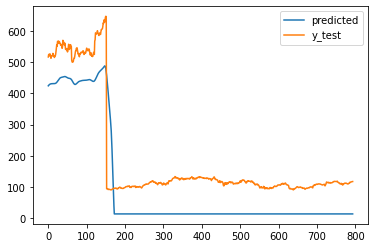

In [68]:
plt.figure()
plt.plot(y_pred_original4, label="predicted")
plt.plot(y_test_original4, label="y_test")
plt.legend(loc = "upper right")
plt.show()

### Conclusion, as we see from graph, only use AAPL, SPY, and XLK gives a worse mean square error compared with other models. For some reason, the prediction goes to zero really quick, which is not acceptible.

## Now, we predict returns with AAPL, SPY, and XLK

In [69]:
# Features engine
df_featured = features_engine(df)

# split
x_data42 = df_featured.iloc[:,1:]
y_data42 = np.array(returns.AAPL[5:]).reshape(-1,1)

# Feature Scaling Normalization
sc = MinMaxScaler(feature_range = (0, 1))
x_data42_sc = sc.fit_transform(x_data42)

# PCA to reduce dimension
pca = PCA(n_components=0.99)
x_data42_pca = pca.fit_transform(x_data42_sc)

# split data
x_train42,x_test42,y_train42,y_test42 = split_data(x_data42_pca,y_data42)

# time-stemp to reshape x to 3 dimension
x_train42, y_train42 = create_timesteps(x_train42, y_train42, days=60)
x_test42, y_test42 = create_timesteps(x_test42, y_test42, days=60)

model42 = createModel(input_shape=(x_train42.shape[1],x_train42.shape[2]))
modelName="model42"

acc, plotFile = trainModel(model42, modelName, x_train42, y_train42, x_test42, y_test42, epochs=40)
# IPython.display.Image(plotFile)

x.shape:  (3357, 60, 3)
y.shape:  (3357, 1)
x.shape:  (794, 60, 3)
y.shape:  (794, 1)
Adding Pool + LSTM block with 50 filters
Adding Pool + LSTM block with 50 filters
Epoch 1/40
27/27 [==============================] - 1s 42ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 2/40
27/27 [==============================] - 0s 13ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 3/40
27/27 [==============================] - 0s 12ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 4/40
27/27 [==============================] - 0s 12ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 5/40
27/27 [==============================] - 0s 12ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 6/40
27/27 [==============================] - 0s 12ms/step - loss: 9.4368e-04 - mse: 9.4368e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 

The mean-square-error is:	0.001


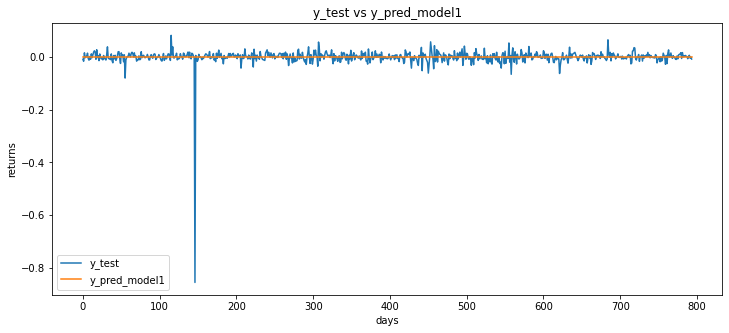

In [70]:
y_pred_model42_test=model42.predict(x_test42)
print(f"The mean-square-error is:\t{mean_squared_error(y_test42, y_pred_model42_test):0.3f}")

plt.figure(figsize=(12,5))
plt.plot(y_test42, label = 'y_test')
plt.plot(y_pred_model42_test, label = 'y_pred_model1')
plt.xlabel('days')
plt.ylabel('returns')
plt.title('y_test vs y_pred_model1')
plt.legend()

# Overall, although it is somehow weird, without other indexes or stocks, model2 is the best predicting model. We also could learn from PCA where it only return number of dimensions as same as the number of features. We cannot help to think that from Close, Open, High, Low, there is only one features we need actually, but which one is more important, it is hard to say. Therefore, I will just leave pca n_components = 1. Now, we should start predicting prices first then calculate the returns later on. And unlike other models, model2 performs well from graph, since it is not going to zero too fast, and therefore the mean-square-error of returns is more valuable and meaningful. If the price goes to zero real fast, then the mean-square-error is more likely to be biased and lower than it support to be. Last reason is that in model1 when we predict returns directly, the results are all zeros, so it is not acceptable as well, how could price be unchangeable? Overall, predict price is ideal. 

# Fine Tune

In [0]:
def createModel(input_shape, num_filters=[50,50,50], pool=[1,1], ps=2, extraDense=True):
  # Create first layer: needs input_spec
  model = Sequential()
  print("Adding Pool + LSTM block with {n:d} filters".format(n=num_filters[0]))
  model.add(LSTM(units = num_filters[0], return_sequences = True, input_shape=input_shape))
  # model.add(Dropout(0.25))

  # Add more Conv/Pooling layers
  for i in range(1, len(num_filters)-1):   
    if  (len(pool) > i) and pool[i]:
      model.add(MaxPooling1D(pool_size=ps,padding='SAME'))

    model.add(LSTM(units = num_filters[i], return_sequences=True))
    model.add(Dropout(0.25))
  
  model.add(LSTM(units = num_filters[i], return_sequences=False))
  model.add(Dropout(0.25))
  
  if extraDense:
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))

  model.add(Dense(1, activation='relu'))

  return model

def trainModel(model, modelName, X_train, y_train, X_test, y_test, batch_size = 128, epochs=20, num_classes=10):
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=.0005, 
                          patience=10, 
                          verbose=0, 
                          mode='auto', 
                          baseline=None, 
                          restore_best_weights=True)

  callbacks = [es_callback, ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)]   

  model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=["mse"])

  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)
  
  model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=callbacks,
            validation_data=(X_test, y_test)
            )
  
  score = model.evaluate(X_test, y_test, verbose=0)

  return score[1], plotFile

In [72]:
x_data = data_featured.iloc[:,1:]
y_data = np.array(data_featured.iloc[:,0]).reshape(-1,1)

# Feature Scaling Normalization
sc = MinMaxScaler(feature_range = (0, 1))
x_data_sc = sc.fit_transform(x_data)
y_data_sc = sc.fit_transform(y_data)

# PCA to reduce dimension
pca = PCA(n_components=0.99)
x_data_pca = pca.fit_transform(x_data_sc)

# split data
x_train,x_test,y_train,y_test = split_data(x_data_pca,y_data_sc)

mse = 10000
bestModel = model2
lst = [60,2]
# Starting Fine Tune:
for i in [7, 30, 60, 90]: # controlling days in create_timestemps
  x_train2, y_train2 = create_timesteps(x_train, y_train, days=i)
  x_test2, y_test2 = create_timesteps(x_test, y_test, days=i)
  for j in [2,3,4]: # control pool_size and numbers of max_pool
    model_temp = createModel(input_shape=(x_train2.shape[1],x_train2.shape[2]),ps=j, pool=[1]*j)
    trainModel(model_temp, 'model_temp', x_train2, y_train2, x_test2, y_test2, epochs=40)
    y_pred_model2_test=model_temp.predict(x_test2)
    y_pred_model2_train=model_temp.predict(x_train2)
    temp = mean_squared_error(y_test2, y_pred_model2_test)
    if temp < mse:
      mse = temp
      bestModel = model_temp
      lst[0]=i
      lst[1]=j
print(f"days:{lst[0]}, pool_size:{lst[1]}")

x.shape:  (3410, 7, 1)
y.shape:  (3410, 1)
x.shape:  (847, 7, 1)
y.shape:  (847, 1)
Adding Pool + LSTM block with 50 filters
Epoch 1/40
27/27 [==============================] - 1s 38ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0949 - val_mse: 0.0949
Epoch 2/40
27/27 [==============================] - 0s 9ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0952 - val_mse: 0.0952
Epoch 3/40
27/27 [==============================] - 0s 9ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 4/40
27/27 [==============================] - 0s 8ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0890 - val_mse: 0.0890
Epoch 5/40
27/27 [==============================] - 0s 8ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0882 - val_mse: 0.0882
Epoch 6/40
27/27 [==============================] - 0s 8ms/step - loss: 7.9937e-04 - mse: 7.9937e-04 - val_loss: 0.0838 - val_mse: 0.0838
Epoch 7/40
27/27 [==============================] - 0s 9ms/step - loss: 9.9823e-04 - m

In [73]:
lst

[90, 3]

As we saw, the best model is using 90 days in our create_timesteps with pool_size 2

The mean-square-error is:	0.006
x.shape:  (764, 90, 1)
y.shape:  (764, 1)


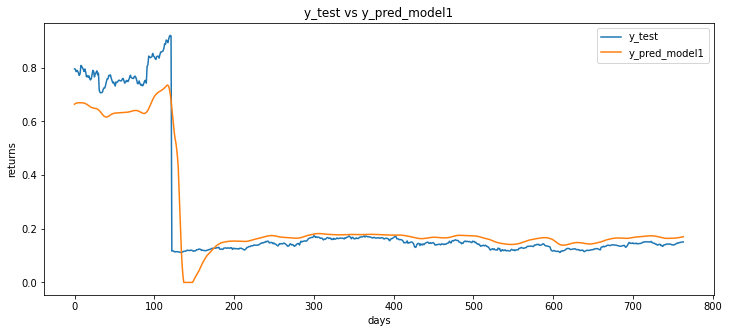

In [74]:
print(f"The mean-square-error is:\t{mse:0.3f}")
x_test2, y_test2 = create_timesteps(x_test, y_test, days=i)
y_pred_bestModel_test=bestModel.predict(x_test2)

plt.figure(figsize=(12,5))
plt.plot(y_test2, label = 'y_test')
plt.plot(y_pred_bestModel_test, label = 'y_pred_model1')
plt.xlabel('days')
plt.ylabel('returns')
plt.title('y_test vs y_pred_model1')
plt.legend()

In [75]:
# ------------------------------------------------------------- Loading Packages ---------------------------------------------------------------------
from tensorflow.keras.models import load_model

import sys
import io
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import fnmatch
import os

from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

from tensorflow.keras import optimizers
from tensorflow.keras.utils import get_file

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import IPython

import warnings
warnings.filterwarnings('ignore')

# ------------------------------------------------------ Loaded Packages and Started My Model ---------------------------------------------------------------------

modelName = "final_model"
model_path = os.path.join(".", modelName)

# Using time-lag idea to get more features
def features_engine(temp):
  data = pd.DataFrame()
  for i in range(temp.shape[1]):
    for j in range(7):
      col_names = temp.columns[i]+":"+str(7-j)+"-days-ago"
      data[col_names]=temp[temp.columns[i]][j:].shift(6-j)
  data = data[6:]
  return data

def create_timesteps(X, Y, days=60):
  x = []
  y = []

  for i in range(days, X.shape[0]-days):
      x.append(X[i:i+days]) # 每days行做一组xi
      y.append(Y[i]) # 每days的倍数作为yi
  x, y = np.array(x), np.array(y)

  # Reshaping
  x = np.reshape(x, (x.shape[0], x.shape[1], X.shape[1]))
  return x, y

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    col_names = ['Open','High','Low','Close']
    remain_list1 = ['AAPL']

    lst = []
    for i in range(len(remain_list1)):
      lst.append(pd.read_csv(f'./data/train/{remain_list1[i]}.csv',index_col='Dt', parse_dates=True).loc[:,col_names])
      lst[i].rename(columns={'Close':f'{remain_list1[i]}-Close', 'High':f'{remain_list1[i]}-high', 'Low':f'{remain_list1[i]}-Low', 'Open':f'{remain_list1[i]}-Open'}, inplace=True)
    df = pd.concat([i for i in lst], axis=1, ignore_index=False) # first 5 attributes belongs to AAPL

    print(df.head())
    # Features engine
    df_featured = features_engine(df)
    print(df_featured.head())
    # split
    x_data = df_featured.iloc[:,1:]
    y_data = np.array(df_featured.iloc[:,0]).reshape(-1,1)

    # PCA to reduce dimension
    pca = PCA(n_components=1)
    x_data_pca = pca.fit_transform(x_data)

    # Feature Scaling Normalization
    sc = MinMaxScaler(feature_range = (0, 1))
    x_data_pca_scaled = sc.fit_transform(x_data_pca)
    y_data_scaled = sc.fit_transform(y_data)

    # time-stemp to reshape x to 3 dimension
    
    x_test, y_test = create_timesteps(x_data_pca_scaled, y_data_scaled, days=90)

    y_pred = model.predict(x_test)

    y_pred_origin = sc.inverse_transform(y_pred)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = pd.DataFrame(y_pred_origin).pct_change(1).tail(200).values
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example you are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    aapl = pd.read_csv(os.path.join(test_dir, "AAPL.csv"))
    
    #dt = aapl.Dt.tail(200)
    ids = aapl.Dt.tail(200).tolist()
    
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = bestModel # CHANGE None to your model !
saveModel(my_model, model_path)

project = "stock_prediction"

holdout_dir = os.path.join(".", "data", "final_project", project, "holdout")
predicts,ids = MyModel(holdout_dir, model_path)

Directory ./final_model already exists, files will be over-written.
Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.
            AAPL-Open  AAPL-high  AAPL-Low  AAPL-Close
Dt                                                    
2000-01-03   104.8750    112.500   101.688     111.938
2000-01-04   108.2500    110.625   101.188     102.500
2000-01-05   103.7500    110.563   103.000     104.000
2000-01-06   106.1183    107.000    95.000      95.000
2000-01-07    96.5000    101.000    95.500      99.500
            AAPL-Open:7-days-ago  ...  AAPL-Close:1-days-ago
Dt                                ...                       
2000-01-11              104.8750  ...                 92.750
2000-01-12              108.2500  ...                 87.188
2000-01-13              103.7500  ...                 96.750
2000-01-14              106.1183  ...                100.438
2000-01-18               96.5000  ...                103.938

[5 rows x 

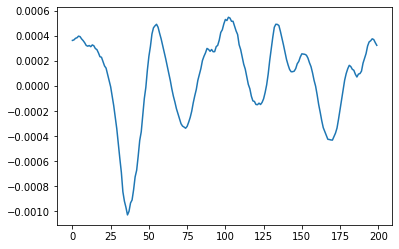

In [76]:
plt.plot(predicts)

In [77]:
print("Done")

Done
